In [2]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%autoreload 2

import sys,os,glob
import psutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint
from skimage import measure
from scipy.optimize import curve_fit

from tqdm import tqdm

from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
from datetime import datetime as dt
import pickle

import datetime as dt
import re
import gc
import matplotlib.animation as animation
import warnings

## current script object
thismodule = sys.modules[__name__]

# Own settings
from settings import *

workdir = os.getcwd()
moduledir, fcndir = defineDir(workdir)

Own modules available: ['casestudy', 'conditionalstats', 'conditionalstats_chunked', 'lifecycle_mapping', 'plot1D', 'plot2D', 'plotCondPDFs']
Own modules available: ['PrecipGrid', 'fcns_load_DYAMOND_SAM', 'fcns_load_RCEMIP_SAM', 'fcns_movie', 'fcns_multiscale_extremes', 'load_TOOCAN_DYAMOND', 'load_TOOCAN_DYAMOND_modif', 'load_TOOCAN_DYAMOND_modif_BF', 'fcns_load_DYAMOND_SAM_Tb_Feng', 'load_TOOCAN_v208_DYAMOND']


In [4]:
%autoreload 2

# to access segmentation files and simulation outputs
from fcns_load_DYAMOND_SAM import *
# to access TOOCAN objects
# from load_TOOCAN_DYAMOND_modif_BF import *
from load_TOOCAN_v208_DYAMOND import *
# mapping function
from lifecycle_mapping import *
# display functions
from fcns_movie import *
# plotting
from plot1D import *
# load own libraries
from conditionalstats import *

# Lagrangian view: P_max vs. normalized age

In [28]:
lcm_RCEMIP_SAM_pkl = pickle.load(open('/homedata/mcarenso/Stage2023_old/SAM/300K/AgeAnalysis.pkl','rb'))
lcm_RCEMIP_ICON_pkl = pickle.load(open('/homedata/mcarenso/Stage2023_old/ICON/300K_no_filter/AgeAnalysis.pkl','rb'))
lcm_RCEMIP_MESONH_pkl = pickle.load(open('/homedata/mcarenso/Stage2023_old/MESONH/300K/AgeAnalysis.pkl','rb'))

# weird

In [29]:
lcm_RCEMIP_ICON_pkl[6]

[22.438368873974017,
 25.918765466711132,
 25.21498388838355,
 31.911914350065373,
 29.884665542576958,
 34.87039926756592,
 36.430009891418415,
 36.52785233207624,
 40.53531859840877,
 47.13173649877617,
 49.11611517558715,
 36.13595311856923,
 50.047004026366295,
 49.11592995861325,
 55.53058759496618,
 49.999665960901915,
 57.06563895952884,
 45.205961293267016,
 50.562605349555895,
 41.85346481746176,
 55.149735599855944,
 54.065857766221264,
 52.28211036028798,
 49.45625755984689,
 54.856396588446174,
 47.548237374122294,
 57.8231450911006,
 50.12453866610243,
 58.65505571070366,
 62.542533619141416,
 51.032612340531195,
 51.83358427300319,
 58.592073162546896,
 52.33777897164347,
 55.66225466174926,
 43.45385172486443,
 57.636827847486934,
 49.15337254660185,
 56.66790130719488,
 53.24430379845947,
 55.46630445914105,
 41.7507582379824,
 51.005486791544556,
 55.50622462975385,
 54.4969684543153,
 41.6440812415263,
 52.16720502421008,
 34.5726183686495,
 50.21095615846113,
 52.766

In [12]:
! ls /homedata/mcarenso/Stage2023_old/

DYAMOND_REGIONS  Figures  ICON	MESONH	README.md  SAM


In [33]:
lcm_RCEMIP_MESONH_csv = pd.read_csv('/homedata/mcarenso/Stage2023_old/MESONH/300K/maxprecip_over_ages.csv')
lcm_RCEMIP_ICON_csv = pd.read_csv('/homedata/mcarenso/Stage2023_old/ICON/300K/maxprecip_over_ages.csv')
lcm_RCEMIP_SAM_csv = pd.read_csv('/homedata/mcarenso/Stage2023_old/SAM/300K/maxprecip_over_ages.csv')

In [36]:
lcm_RCEMIP_MESONH_csv

,Ages_of_MaxPrecip,MaxPrecip_over_ages
0,0.050000,27.614353
1,0.052632,32.831360
2,0.055556,33.118827
3,0.058824,31.576800
4,0.062500,34.552645
...,...,...
123,0.941176,4.441169
124,0.944444,4.377196
125,0.947368,2.721921
126,0.950000,1.968799


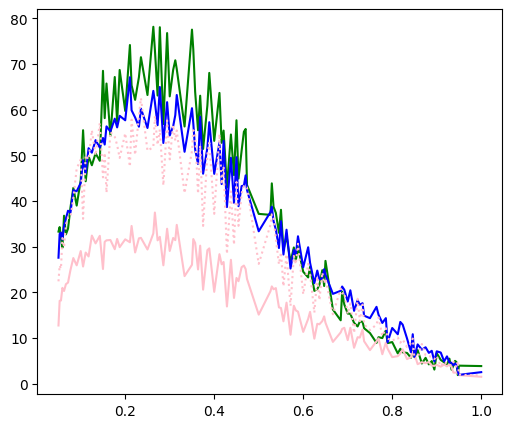

In [35]:
# Compare both datasets

fig, ax = plt.subplots(figsize=(6,5))

models = ['SAM','ICON','MESONH']
cols = dict(zip(models,['green','pink','blue']))

for model in models:
    
    # csv
    lcm_obj = getattr(thismodule,'lcm_RCEMIP_%s_csv'%model)
    ax.plot(lcm_obj.Ages_of_MaxPrecip,lcm_obj.MaxPrecip_over_ages,c=cols[model])

# pkl
ax.plot(lcm_RCEMIP_ICON_pkl[5],lcm_RCEMIP_ICON_pkl[6],c=cols['ICON'],linestyle = ':')

In [39]:
# Load all correct versions in csv format for later plotting

lcm_RCEMIP_MESONH = pd.read_csv('/homedata/mcarenso/Stage2023_old/MESONH/300K/maxprecip_over_ages.csv')
lcm_RCEMIP_ICON_pkl = pickle.load(open('/homedata/mcarenso/Stage2023_old/ICON/300K_no_filter/AgeAnalysis.pkl','rb'))
lcm_RCEMIP_ICON = pd.DataFrame(data={'Ages_of_MaxPrecip': lcm_RCEMIP_ICON_pkl[5], 'MaxPrecip_over_ages': lcm_RCEMIP_ICON_pkl[6]})
lcm_RCEMIP_SAM = pd.read_csv('/homedata/mcarenso/Stage2023_old/SAM/300K/maxprecip_over_ages.csv')

In [41]:
# Load DYAMOND version

filepath = os.path.join(DIR_OUT,'tropics','life_cycle_mapping','lifecycle_diag_DYAMOND_Summer_SAM_v208_2.nc')
lcm_data = xr.open_dataset(filepath)


In [42]:
#-- compute normalized age, DYAMOND

# coord number
N_labels = lcm_data.MCS_label.size
N_ages = lcm_data.age.size
# define matrix of ages as stored in database
age_2D = np.repeat(lcm_data.age.data[np.newaxis,:],N_labels,axis=0)
# mask nans after MCS death
mask_dead = np.isnan(lcm_data.area)
age_2D[mask_dead] = np.nan
# define matrix of durations ages as stored in database
durations_2D = np.repeat(lcm_data.duration.data[:,np.newaxis],N_ages,axis=1)
# define matrix of normalized ages as stored in database
norm_age_2D = age_2D/durations_2D

# flatten arrays
norm_age_1D = norm_age_2D.flatten()
prec_max_1D = lcm_data.prec_max.data.flatten()


In [113]:
#-- Compute conditional mean prec_max on normalized MCS age

# flatten arrays
norm_age_1D = norm_age_2D.flatten()
prec_max_1D = lcm_data.prec_max.data.flatten()

#-- use distribution class to compure reference distribution of ages
# initialize
dist_normage_lin = Distribution(name='normage',nbins=100)
# compute distribution
dist_normage_lin.computeDistribution(sample=norm_age_1D,vmin=0,vmax=1)
# compute locations of bins
dist_normage_lin.storeBinLocations(sample=norm_age_1D,sizemax=100)

#-- use ConditionalDistribution class to map prec_max onto 
cdist_precmax_on_normage = ConditionalDistribution(name='prec_max_on_norm_age',
                                                   is3D=False,
                                                   on=dist_normage_lin)
cdist_precmax_on_normage.computeConditionalMeanAndVariance(prec_max_1D)
# percentiles
for rank in [5,25,50,75,95]:
    cdist_precmax_on_normage.computeConditionalPercentile(prec_max_1D,rank)

/home/bfildier/analyses/explore-multiscale-extremes/modules/conditionalstats.py:1086: RuntimeWarning: Mean of empty slice
  out[i_b] = fun(subsample)
/home/bfildier/analyses/explore-multiscale-extremes/modules/conditionalstats.py:1086: RuntimeWarning: Degrees of freedom <= 0 for slice.
  out[i_b] = fun(subsample)


In [114]:
for rank in [5,25,50,75,95]:
    cdist_precmax_on_normage.computeConditionalPercentile(prec_max_1D,rank)

/home/bfildier/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


In [48]:
#-- Show RCEMIP and DYAMOND-SAM data --#

In [55]:
cdist_precmax_on_normage

< ConditionalDistribution object:
 . name: prec_max_on_norm_age
 . is3D: False
 . isTime: False
 . on: <class 'conditionalstats.Distribution'>
 . mean: None
 . cond_mean: <class 'numpy.ndarray'>
 . cond_var: <class 'numpy.ndarray'>
 . cond_std: <class 'numpy.ndarray'>
 . cond_perc75: <class 'numpy.ndarray'>
 . cond_perc5: <class 'numpy.ndarray'>
 . cond_perc25: <class 'numpy.ndarray'>
 . cond_perc50: <class 'numpy.ndarray'>
 . cond_perc95: <class 'numpy.ndarray'>
 >

In [79]:
import matplotlib._color_data as mcd
from scipy.signal import savgol_filter

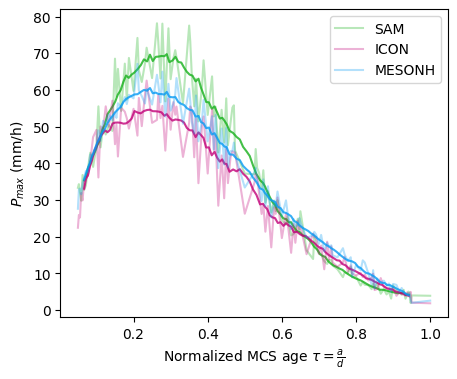

In [97]:
per30mn_to_per_hr = 2

fig, ax = plt.subplots(figsize=(5,4))

#- RCEMIP

models = ['SAM','ICON','MESONH']
cols = dict(zip(models,[mcd.XKCD_COLORS["xkcd:green"],mcd.XKCD_COLORS["xkcd:magenta"],mcd.XKCD_COLORS["xkcd:azure"]]))

for model in models:
    
    lcm_obj = getattr(thismodule,'lcm_RCEMIP_%s'%model)
    
    # data
    x = lcm_obj.Ages_of_MaxPrecip
    y = lcm_obj.MaxPrecip_over_ages
    
    # smooth
    box_pts = 10
    box = np.ones(box_pts)/box_pts
    x_smooth = np.convolve(x, box, mode='valid')
    y_smooth = np.convolve(y, box, mode='valid')
    
    # show
    ax.plot(x,y,c=cols[model],alpha=0.3,label=model)
    ax.plot(x_smooth,y_smooth,c=cols[model],alpha=0.8)

ax.set_xlabel(r'Normalized MCS age $\tau=\frac{a}{d}$')
ax.set_ylabel(r'$P_{max}$ (mm/h)')
ax.legend()

plt.savefig(os.path.join(DIR_FIG,'lifecycle','EGU24_RCEMIP_Pmax_normage.pdf'),bbox_inches='tight')

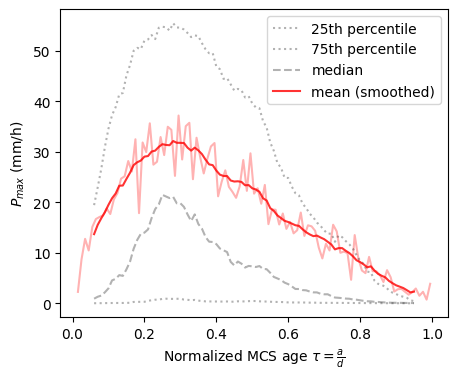

In [124]:
per30mn_to_per_hr = 2

fig, ax = plt.subplots(figsize=(5,4))


#- DYAMOND SAM

x = cdist_precmax_on_normage.on.percentiles
x_smooth = np.convolve(x, box, mode='valid')
# y = cdist_precmax_on_normage.cond_mean*per30mn_to_per_hr
y_mean = cdist_precmax_on_normage.cond_mean*per30mn_to_per_hr
y_med = cdist_precmax_on_normage.cond_perc50*per30mn_to_per_hr
y_med_smooth = np.convolve(y_med, box, mode='valid')
y_mean_smooth = np.convolve(y_mean, box, mode='valid')
# error range
y_top = cdist_precmax_on_normage.cond_perc75*per30mn_to_per_hr
y_top_smooth = np.convolve(y_top, box, mode='valid')
y_bot = cdist_precmax_on_normage.cond_perc25*per30mn_to_per_hr
y_bot_smooth = np.convolve(y_bot, box, mode='valid')

# # raw
# ax.fill_between(x,y_bot,y_top,color='k',edgecolor=None,alpha=0.01)
# ax.plot(x,y_bot,'k',alpha=0.3,linestyle=':',label='25th percentile')
# ax.plot(x,y_top,'k',alpha=0.3,linestyle=':',label='75th percentile')
# ax.plot(x,y_med,'k',alpha=0.3,linestyle='--',label='median')
ax.plot(x,y_mean,'r',linestyle='-',alpha=0.3)#,label='mean')

# smoothed
# ax.fill_between(x_smooth,y_bot_smooth,y_top_smooth,color='k',edgecolor=None,alpha=0.01)
ax.plot(x_smooth,y_bot_smooth,'k',alpha=0.3,linestyle=':',label='25th percentile')
ax.plot(x_smooth,y_top_smooth,'k',alpha=0.3,linestyle=':',label='75th percentile')
ax.plot(x_smooth,y_med_smooth,'k',alpha=0.3,linestyle='--',label='median')
ax.plot(x_smooth,y_mean_smooth,'r',linestyle='-',label='mean (smoothed)',alpha=0.8)


ax.set_xlabel(r'Normalized MCS age $\tau=\frac{a}{d}$')
ax.set_ylabel(r'$P_{max}$ (mm/h)')
ax.legend()

plt.savefig(os.path.join(DIR_FIG,'lifecycle','EGU24_DYAMOND_SAM_Pmax_normage.pdf'),bbox_inches='tight')